## PROTOTYPE Meridional Overturning in Potential Density Coordinates
here is my prototyped meridional overturning script.
this script is currently using the first 12 months of ecco data starting on Jan 16th, 1992
the demo data is stored in "./demo_nctiles_monthly/"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr


from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco


from netCDF4 import Dataset

import seawater

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import derive_potential_density_values_TEST
from analysis_package import ecco_masks

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
######################################################################################################################
################################## DEFINE DATA FILES AND THEIR ASSOCIATED PATHS ######################################
######################################################################################################################

# complete_data_dir contains ECCO state data over the entire dataset time range (1992-2016, 288 monthly mean time steps)
complete_data_dir = "./nctiles_monthly/"
# dem_dir conatins ECCO state data truncated to the first 12 monthly mean time steps
demo_dir = "./demo_nctiles_monthly/"
data_dir = complete_data_dir

# UVELMASS is the ECCO eulerian flow velocity in the (native-grid)  x-direction
UVELMASS_var = "UVELMASS"
# VVELMASS is the ECCO eulerian flow velocity in the (native-grid) y-direction
VVELMASS_var = "VVELMASS"
# BOLUS_UVEL is the ECCO lagrangian flow velocity in the (native-grid)  x-direction
BOLUS_UVEL_var = "BOLUS_UVEL"
# BOLUS_VVEL is the ECCO lagrangian flow velocity in the (native-grid) y-direction
BOLUS_VVEL_var = "BOLUS_VVEL"

# RHOAnoma: insitu density anomaly
RHOAnoma_var_str = "RHOAnoma"
# PHIHYD: insitu pressure anomaly with respect to the depth integral of gravity and reference density (g*rho_reference)
PHIHYD_var_str = "PHIHYD"
# SALT: insitu salinity (psu)
SALT_var_str = "SALT"
# THETA: potential pressure (C)
THETA_var_str = "THETA"
# PDENS: Potential density at sigma 2
PDENS_var_str = "PDENS"

# PDENS_U: Potential density interpolated to local grid cell "u" (i_g,j) points at sigma 2
PDENS_U_var_str = "PDENS_U"

# PDENS_V: Potential density interpolated to local grid cell "v" (i,j_g) points at sigma 2
PDENS_V_var_str = "PDENS_V"

In [4]:
######################################################################################################################
############################################ DEFINE TIMESLICE ########################################################
######################################################################################################################

time_slice = np.arange(0,12)
        

In [5]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################


grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)

In [6]:
######################################################################################################################
################################################### LOAD DATA ########################################################
######################################################################################################################

# load data files from central directory
UVELMASS_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, UVELMASS_var, time_slice)
VVELMASS_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, VVELMASS_var, time_slice)
BOLUS_UVEL_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, BOLUS_UVEL_var, time_slice,
                                                                rename_indices=False)
BOLUS_VVEL_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, BOLUS_VVEL_var, time_slice,
                                                                rename_indices=False)
# set data file indecies starting from zero.
UVELMASS_ds_raw = UVELMASS_ds_raw.assign_coords(i_g=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),
                                                time=time_slice)
VVELMASS_ds_raw = VVELMASS_ds_raw.assign_coords(i=np.arange(0,90),j_g=np.arange(0,90),k=np.arange(0,50),
                                                time=time_slice)
BOLUS_UVEL_raw = BOLUS_UVEL_raw.assign_coords(i_g=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),
                                              time=time_slice)
BOLUS_VVEL_raw = BOLUS_VVEL_raw.assign_coords(i=np.arange(0,90),j_g=np.arange(0,90),k=np.arange(0,50),
                                              time=time_slice)  

Loaded UVELMASS over time slice  

Loaded VVELMASS over time slice  

Loaded BOLUS_UVEL over time slice  

Loaded BOLUS_VVEL over time slice  



In [7]:
print(UVELMASS_ds_raw)

<xarray.Dataset>
Dimensions:   (i_g: 90, j: 90, k: 50, tile: 13, time: 12)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    dep       (k) float64 5.0 15.0 25.0 35.0 ... 5.039e+03 5.461e+03 5.906e+03
    tim       (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16
    lon       (tile, j, i_g) float64 -115.0 -115.0 -115.0 ... -102.9 -109.0
    lat       (tile, j, i_g) float64 -88.24 -88.38 -88.52 ... -88.08 -88.1
Dimensions without coordinates: tile
Data variables:
    UVELMASS  (tile, time, k, j, i_g) float64 nan nan nan nan ... nan nan nan
    timstep   (tile, time) float64 732.0 1.428e+03 ... 8.028e+03 8.772e+03
    land      (tile, k, j, i_g) float64 nan nan nan nan nan ... nan nan nan nan
    area      (tile, j, i_g)

In [8]:
######################################################################################################################
################################## CALCULATE POTENTIAL DENSITY #######################################################
######################################################################################################################


# calculate potential density and in situ pressure
PDENS_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,PDENS_var_str,time_slice,rename_indices=False)
# set data file indecies starting from zero.
PDENS_ds = PDENS_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice)


# calculate potential density and in situ pressure
PDENS_U_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,PDENS_U_var_str,time_slice,rename_indices=False)
# set data file indecies starting from zero.
PDENS_U_ds = PDENS_U_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice)
# calculate potential density and in situ pressure
PDENS_V_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,PDENS_V_var_str,time_slice,rename_indices=False)
# set data file indecies starting from zero.
PDENS_V_ds = PDENS_V_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice)


Loaded PDENS over time slice  

Loaded PDENS_U over time slice  

Loaded PDENS_V over time slice  



In [14]:
print(PDENS_U_ds.time)


<xarray.DataArray 'time' (time: 12)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16


In [15]:
print(UVELMASS_ds_raw.time)

<xarray.DataArray 'time' (time: 12)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16


In [11]:
######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################

maskW = (UVELMASS_ds_raw.UVELMASS.isel(k=0,time=1)*0 + 1.)
maskS = (VVELMASS_ds_raw.VVELMASS.isel(k=0,time=1)*0 + 1.)
maskC = (PDENS_ds.PDENS.isel(k=0,time=0)*0 + 1.)


southern_ocean_mask_W, southern_ocean_mask_S, so_atl_basin_mask_W, so_atl_basin_mask_S, so_indpac_basin_mask_W, so_indpac_basin_mask_S = ecco_masks.get_basin_masks(maskW, maskS, maskC)

so_atl_basin_mask_W.load()

<xarray.DataArray (tile: 13, j: 90, i_g: 90)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.]],

       [[ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.],
        ...,
        [ 1.,  1., ..., nan, nan],
        [ 1.,  1., ..., nan, nan]],

       ...,

       [[nan, nan, ...,  1.,  1.],
        [nan, nan, ...,  1.,  1.],
        ...,
        [ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.]],

       [[ 1.,  1., ..., nan, nan],
        [ 1.,  1., ..., nan, nan],
        ...,
        [ 1.,  1., ..., nan, nan],
        [ 1.,  1., ..., nan, nan]]])
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    k        int64 0
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    dep      float64 5.0
    lon      (tile, j, i_g) float64 -115.0 -115.

In [18]:
print(UVELMASS_ds_raw.time)
print(VVELMASS_ds_raw.time)

<xarray.DataArray 'time' (time: 12)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16
<xarray.DataArray 'time' (time: 12)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16


In [19]:
print(BOLUS_UVEL_raw.time)


<xarray.DataArray 'time' (time: 12)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16


In [21]:
######################################################################################################################
############################### CALCULATE TRANSPORT IN POTENTIAL DENSITY SPACE #######################################
######################################################################################################################


cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)

transport_x = (UVELMASS_ds_raw["UVELMASS"].fillna(0)*grid["drF"]*grid["dyG"] 
               + BOLUS_UVEL_raw["bolus_uvel"].fillna(0)*grid["drF"]*grid["dyG"]*grid["hFacW"])*so_atl_basin_mask_W
transport_y = (VVELMASS_ds_raw["VVELMASS"].fillna(0)*grid["drF"]*grid["dxG"] 
               + BOLUS_VVEL_raw["bolus_vvel"].fillna(0)*grid["drF"]*grid["dxG"]*grid["hFacS"])*so_atl_basin_mask_S

# create infrastructure for integrating in depth space

lat_vals = np.arange(-88,88)

# create an empty array with a stretched depth dimension
# Set the coordinates of the stretched depth dimension to potential density values..
# add padding to either end of the pot. density coordinates
# just trying with slightly coarser resolution 
#(what pot density resolution is valid in this case?)
pot_dens_coord = np.arange(1033.1,1037.51,0.2)

#pot_dens_coord = np.concatenate((np.asarray([1000.]),pot_dens_coord, np.arange(1036.7,1037.31,0.05)))

# set dimensions based on input dataset with modified vertical level spacing..
pot_dens_dims = (len(time_slice),
                 len(pot_dens_coord),
                 len(lat_vals))

empty_pot_coords_data = np.zeros(pot_dens_dims)
# trying to make this as general as possible, but need to keep an eye on this..
new_coords = [time_slice, pot_dens_coord, lat_vals]
new_dims = ["time", "pot_rho", "lat"]



pot_dens_array = PDENS_ds.PDENS.copy(deep=True)

pot_dens_array_x = PDENS_U_ds.PDENS.copy(deep=True)*so_atl_basin_mask_W
pot_dens_array_y = PDENS_V_ds.PDENS.copy(deep=True)*so_atl_basin_mask_S

depth_integrated_pdens_transport = xr.DataArray(data=empty_pot_coords_data,coords=new_coords,dims=new_dims)
depth_integrated_pdens_transport.load()
depth_integrated_pdens_transport_latx = depth_integrated_pdens_transport.copy(deep=True)
depth_integrated_pdens_transport_latx.load()
depth_integrated_pdens_transport_laty = depth_integrated_pdens_transport.copy(deep=True)
depth_integrated_pdens_transport_laty.load()

depth_integrated_x_interp_results = depth_integrated_pdens_transport.copy(deep=True)
depth_integrated_x_interp_results.load()
depth_integrated_y_interp_results = depth_integrated_pdens_transport.copy(deep=True)
depth_integrated_y_interp_results.load()

depth_integrated_x_pdens_transport_no_interp = depth_integrated_pdens_transport.copy(deep=True)
depth_integrated_x_pdens_transport_no_interp.load()
depth_integrated_y_pdens_transport_no_interp = depth_integrated_pdens_transport.copy(deep=True)
depth_integrated_y_pdens_transport_no_interp.load()


for density in pot_dens_coord:
    print("Started " + str(density) + " surface") 
    potdens_stencil_x_0 = pot_dens_array_x > density
    potdens_stencil_y_0 = pot_dens_array_y > density
    # this step is critical to remove low density anomalies in the deep ocean from stencil...
    potdens_stencil_x = potdens_stencil_x_0.cumsum(dim="k") > 0
    potdens_stencil_y = potdens_stencil_y_0.cumsum(dim="k") > 0
    print("got to checkpoint 0")

    
    ##################################################################################################################
    ###########################################     START INTERPOLATION    ###########################################
    ##################################################################################################################
    
    # set end-appended value equal to 1 for subtraction step..
    potdens_stencil_x_shifted_up_one_cell = xr.concat((potdens_stencil_x.isel(k=slice(1,50)),
                                                       potdens_stencil_x.isel(k=49)),
                                                      dim="k").assign_coords(k=np.arange(0,50))
    potdens_stencil_y_shifted_up_one_cell = xr.concat((potdens_stencil_y.isel(k=slice(1,50)),
                                                       potdens_stencil_y.isel(k=49)),
                                                      dim="k").assign_coords(k=np.arange(0,50))
    potdens_stencil_x_shifted_down_one_cell = xr.concat((potdens_stencil_x.isel(k=0)*0,
                                                         potdens_stencil_x.isel(k=slice(0,49))),
                                                        dim="k").assign_coords(k=np.arange(0,50))
    potdens_stencil_y_shifted_down_one_cell = xr.concat((potdens_stencil_y.isel(k=0)*0,
                                                         potdens_stencil_y.isel(k=slice(0,49))),
                                                        dim="k").assign_coords(k=np.arange(0,50))

    potdens_stencil_x_one_above_top_level = potdens_stencil_x_shifted_up_one_cell*1 - potdens_stencil_x*1
    potdens_stencil_y_one_above_top_level = potdens_stencil_y_shifted_up_one_cell*1 - potdens_stencil_y*1
    # get rid of trailing negative values that occur at the ocean's bottom boundary..
    potdens_stencil_x_one_above_top_level = potdens_stencil_x_one_above_top_level.where(potdens_stencil_x_one_above_top_level > 0,
                                                                                        other=0)
    potdens_stencil_y_one_above_top_level = potdens_stencil_y_one_above_top_level.where(potdens_stencil_y_one_above_top_level > 0,
                                                                                        other=0)

    potdens_stencil_x_top_level = potdens_stencil_x*1 - potdens_stencil_x_shifted_down_one_cell*1
    potdens_stencil_y_top_level = potdens_stencil_y*1 - potdens_stencil_y_shifted_down_one_cell*1
    # turn zeros into nans..
    # NOTE SOMETIMES YOU GET PROTRUSIONS OF DENSITY ANOMALIES THAT SEEM TO CREATE TWO DENSITY SURFACES, LEADING TO A VALUE OF
    # 2 IN THE STENCIL.. I eliminated this using "potdens_stencil_x = potdens_stencil_x_0.cumsum(dim="k") > 0" a couple lines above.
    potdens_stencil_x_top_level = potdens_stencil_x_top_level.where(potdens_stencil_x_top_level > 0, other=np.nan)
    potdens_stencil_y_top_level = potdens_stencil_y_top_level.where(potdens_stencil_y_top_level > 0, other=np.nan)
    potdens_stencil_x_one_above_top_level = potdens_stencil_x_one_above_top_level.where(potdens_stencil_x_one_above_top_level > 0,
                                                                                        other=np.nan)
    potdens_stencil_y_one_above_top_level = potdens_stencil_y_one_above_top_level.where(potdens_stencil_y_one_above_top_level > 0,
                                                                                        other=np.nan)
    # multiply depth values by -1 to make them positive..
    depth_above_x_top_level_raw = (-1*potdens_stencil_x_one_above_top_level.fillna(0)*transport_x.Z).sum(dim="k")
    depth_x_top_level_raw = (-1*potdens_stencil_x_top_level.fillna(0)*transport_x.Z).sum(dim="k",skipna=True)
    depth_above_y_top_level_raw = (-1*potdens_stencil_y_one_above_top_level.fillna(0)*transport_y.Z).sum(dim="k",skipna=True)
    depth_y_top_level_raw = (-1*potdens_stencil_y_top_level.fillna(0)*transport_y.Z).sum(dim="k",skipna=True)
    # turn zeros into nans..
    depth_above_x_top_level = depth_above_x_top_level_raw.where(depth_above_x_top_level_raw > 0, other=np.nan)
    depth_x_top_level = depth_x_top_level_raw.where(depth_x_top_level_raw > 0, other=np.nan)
    depth_above_y_top_level = depth_above_y_top_level_raw.where(depth_above_y_top_level_raw > 0, other=np.nan)
    depth_y_top_level = depth_y_top_level_raw.where(depth_y_top_level_raw > 0, other=np.nan)

    thickness_above_x_top_level_raw = (potdens_stencil_x_one_above_top_level.fillna(0)*grid["drF"]).sum(dim="k")
    thickness_x_top_level_raw = (potdens_stencil_x_top_level.fillna(0)*grid["drF"]).sum(dim="k")
    thickness_above_y_top_level_raw = (potdens_stencil_y_one_above_top_level.fillna(0)*grid["drF"]).sum(dim="k")
    thickness_y_top_level_raw = (potdens_stencil_y_top_level.fillna(0)*grid["drF"]).sum(dim="k")
    # turn zeros into nans..
    thickness_above_x_top_level = thickness_above_x_top_level_raw.where(thickness_above_x_top_level_raw > 0, other=np.nan)
    thickness_x_top_level = thickness_x_top_level_raw.where(thickness_x_top_level_raw > 0, other=np.nan)
    thickness_above_y_top_level = thickness_above_y_top_level_raw.where(thickness_above_y_top_level_raw > 0, other=np.nan)
    thickness_y_top_level = thickness_y_top_level_raw.where(thickness_y_top_level_raw > 0, other=np.nan)    
    
    potdens_above_x_top_level = (potdens_stencil_x_one_above_top_level.fillna(0)*pot_dens_array_x.fillna(0)).sum(dim="k")
    potdens_x_top_level = (potdens_stencil_x_top_level.fillna(0)*pot_dens_array_x.fillna(0)).sum(dim="k")
    potdens_above_y_top_level = (potdens_stencil_y_one_above_top_level.fillna(0)*pot_dens_array_y.fillna(0)).sum(dim="k")
    potdens_y_top_level = (potdens_stencil_y_top_level.fillna(0)*pot_dens_array_y.fillna(0)).sum(dim="k")
    # turn zeros into nans..
    potdens_above_x_top_level = potdens_above_x_top_level.where(potdens_above_x_top_level > 0, other=np.nan)
    potdens_x_top_level = potdens_x_top_level.where(potdens_x_top_level > 0, other=np.nan)
    potdens_above_y_top_level = potdens_above_y_top_level.where(potdens_above_y_top_level > 0, other=np.nan)
    potdens_y_top_level = potdens_y_top_level.where(potdens_y_top_level > 0, other=np.nan)
    
    print("got to checkpoint 1")
    # need to calculate transport per m so divide by cell thickness
    transport_per_meter_above_x_top_level = (potdens_stencil_x_one_above_top_level.fillna(0)*transport_x/grid["drF"]).sum(dim="k")
    transport_per_meter_x_top_level = (potdens_stencil_x_top_level.fillna(0)*transport_x/grid["drF"]).sum(dim="k")
    transport_per_meter_above_y_top_level = (potdens_stencil_y_one_above_top_level.fillna(0)*transport_y/grid["drF"]).sum(dim="k")
    transport_per_meter_y_top_level = (potdens_stencil_y_top_level.fillna(0)*transport_y/grid["drF"]).sum(dim="k")
    
    transport_per_meter_above_x_top_level = transport_per_meter_above_x_top_level.where(transport_per_meter_above_x_top_level !=0, other=np.nan)    
    transport_per_meter_x_top_level = transport_per_meter_x_top_level.where(transport_per_meter_x_top_level != 0, other=np.nan)
    transport_per_meter_above_y_top_level = transport_per_meter_above_y_top_level.where(transport_per_meter_above_y_top_level !=0, other=np.nan)
    transport_per_meter_y_top_level = transport_per_meter_y_top_level.where(transport_per_meter_y_top_level !=0, other=np.nan)
    
    depth_potdens_slope_x = (depth_above_x_top_level - depth_x_top_level)/(potdens_above_x_top_level - potdens_x_top_level)                                                         
    depth_potdens_slope_y = (depth_above_y_top_level - depth_y_top_level)/(potdens_above_y_top_level - potdens_y_top_level)
        
    #transport_slope_x = (transport_per_meter_above_x_top_level - transport_per_meter_x_top_level)/(depth_above_x_top_level - depth_x_top_level)
    #transport_slope_y = (transport_per_meter_above_y_top_level - transport_per_meter_y_top_level)/(depth_above_y_top_level - depth_y_top_level)   
    
    # this is an issue... need to account for those low desnity protrusions..
    h_array_x_0 = (density - potdens_x_top_level)*depth_potdens_slope_x
    h_array_x = h_array_x_0.where(h_array_x_0 < 0, other=0 )
    h_array_y_0 = (density - potdens_y_top_level)*depth_potdens_slope_y 
    h_array_y = h_array_y_0.where(h_array_y_0 < 0, other=0 )
    print("got to checkpoint 2")
    
    trsp_interpolated_x = ((density - potdens_x_top_level)*depth_potdens_slope_x - thickness_x_top_level/2)*transport_per_meter_above_x_top_level
    trsp_interpolated_y = ((density - potdens_y_top_level)*depth_potdens_slope_y - thickness_y_top_level/2)*transport_per_meter_above_y_top_level
    
    # "transport_integral_x/y" is the vertical sum of the interpolated grid cell tranposrt
    trsp_interpolated_x.load()
    trsp_interpolated_y.load()
    
    ##################################################################################################################
    ###########################################     END INTERPOLATION    #############################################
    ##################################################################################################################   
    
    
    # split the top cell in half since we are putting it into the interpolation,
    # but only in cases where there actually is a cell above it.
    depth_integrated_trsp_x = transport_x*(potdens_stencil_x.where(potdens_stencil_x>0,other=np.nan))
    depth_integrated_trsp_x.load()
    depth_integrated_trsp_x = depth_integrated_trsp_x.sum(dim='k') + trsp_interpolated_x.fillna(0)
    
    depth_integrated_trsp_y = transport_y*(potdens_stencil_y.where(potdens_stencil_y>0,other=np.nan))
    depth_integrated_trsp_y.load()
    depth_integrated_trsp_y = depth_integrated_trsp_y.sum(dim='k') + trsp_interpolated_y.fillna(0)
    
    depth_integrated_trsp_x_no_interp = (transport_x*potdens_stencil_x).sum(dim='k')
    depth_integrated_trsp_x_no_interp.load()
    depth_integrated_trsp_y_no_interp = (transport_y*potdens_stencil_y).sum(dim='k')
    depth_integrated_trsp_y_no_interp.load()
                                          
                                           
    print('starting lat-band filtering')
    for lat in lat_vals:
        # Compute mask for particular latitude band
        print(str(lat)+' ',end='')
        # since transport values are in native grid coordaintes you need to combine the sum of the transports in 
        # the x and y direction and vis versa for tiles 0-5 and 7-12, respectively
        lat_maskX, lat_maskY = ecco.vector_calc.get_latitude_masks(lat, cds['YC'], grid_xmitgcm)
       
        # Sum horizontally
        lat_trsp_x = (depth_integrated_trsp_x * lat_maskX).sum(dim=['i_g','j','tile'],skipna=True)
        lat_trsp_y = (depth_integrated_trsp_y * lat_maskY).sum(dim=['i','j_g','tile'],skipna=True)
        lat_trsp_x_interp = (trsp_interpolated_x * lat_maskX).sum(dim=['i_g','j','tile'],skipna=True)
        lat_trsp_y_interp = (trsp_interpolated_y * lat_maskY).sum(dim=['i','j_g','tile'],skipna=True)
        # data for overturning with no interpolation..
        lat_trsp_x_no_interp = (depth_integrated_trsp_x_no_interp * lat_maskX).sum(dim=['i_g','j','tile'],skipna=True)
        lat_trsp_y_no_interp = (depth_integrated_trsp_y_no_interp * lat_maskY).sum(dim=['i','j_g','tile'],skipna=True)
        
        depth_integrated_pdens_transport_latx.loc[{'lat':lat,'pot_rho':density}] = lat_trsp_x
        depth_integrated_pdens_transport_laty.loc[{'lat':lat,'pot_rho':density}] = lat_trsp_y
        depth_integrated_x_interp_results.loc[{'lat':lat,'pot_rho':density}] = lat_trsp_x_interp
        depth_integrated_y_interp_results.loc[{'lat':lat,'pot_rho':density}] = lat_trsp_y_interp
        depth_integrated_x_pdens_transport_no_interp.loc[{'lat':lat,'pot_rho':density}] = lat_trsp_x_no_interp
        depth_integrated_y_pdens_transport_no_interp.loc[{'lat':lat,'pot_rho':density}] = lat_trsp_y_no_interp                                

    print("\n")
    
    



Started 1033.1 surface
got to checkpoint 0
got to checkpoint 1
got to checkpoint 2
starting lat-band filtering
-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 

Started 1033.3 surface
got to checkpoint 0
got to checkpoint 1
got to checkpoint 2
starting lat-band filtering
-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44

-88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 



## OUTPUT PLOTS

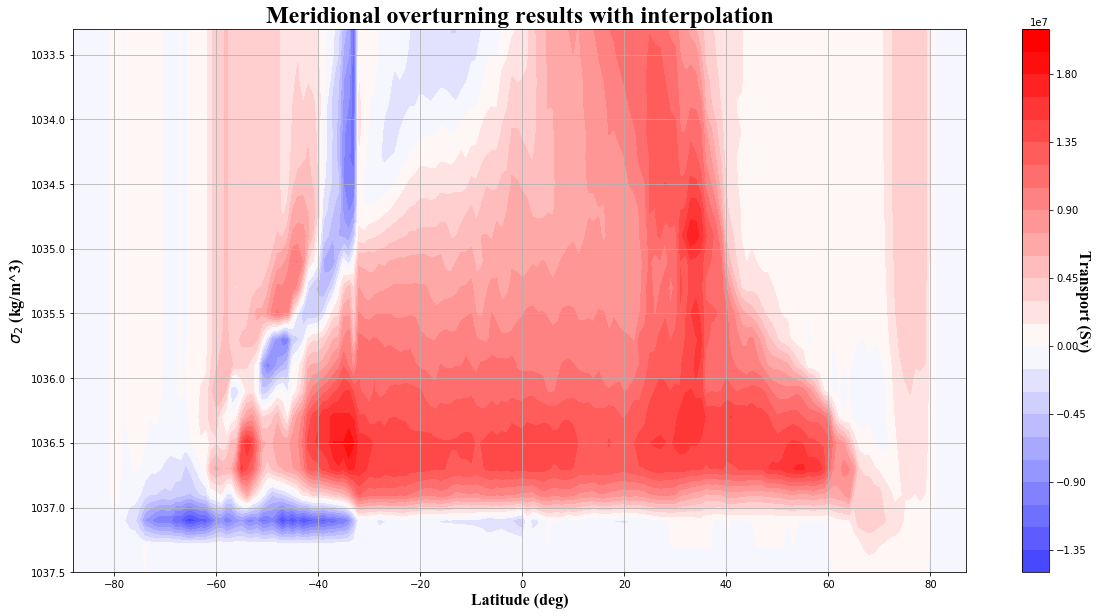

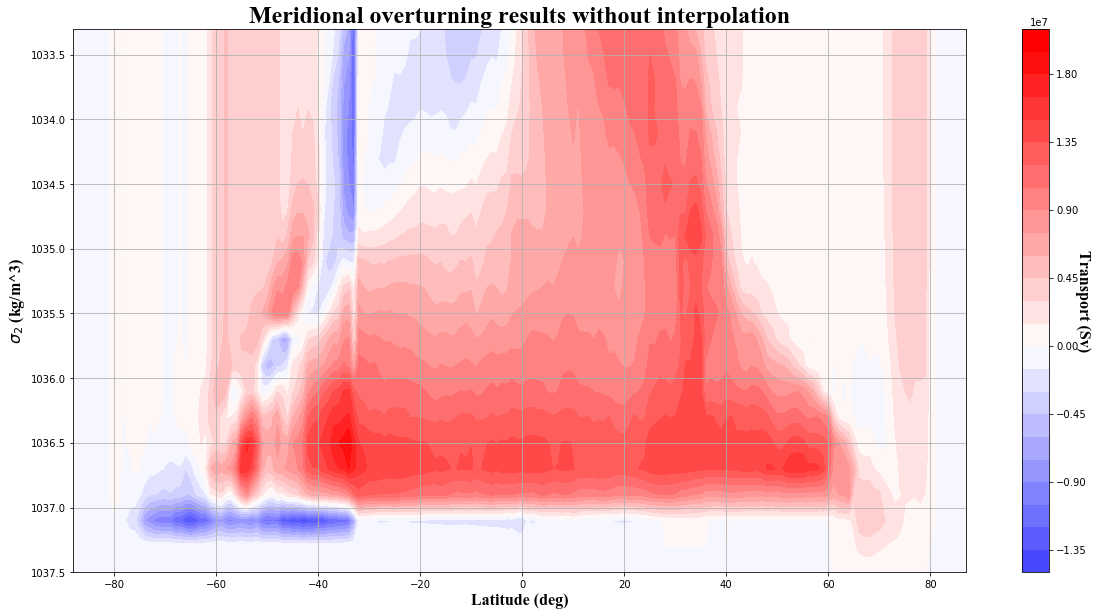

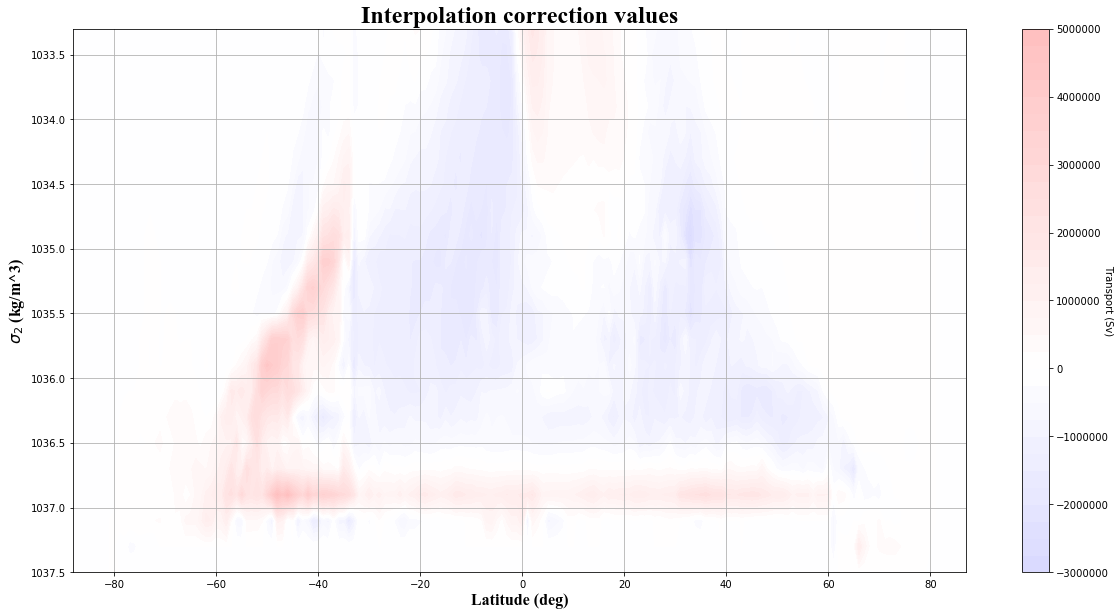

In [22]:
min_lat = 0
max_lat = 178
d_levels = np.arange(0,50)

pvmin = -2e7
pvmax = 2e7

plt.figure(figsize=(20,10))
#vmin = depth_integrated_pdens_transport.min()
#vmax = depth_integrated_pdens_transport.max()
plt.contourf(depth_integrated_pdens_transport_laty.lat[min_lat:max_lat],
             depth_integrated_pdens_transport_laty.pot_rho[1:],
             -1*depth_integrated_pdens_transport_laty.mean(dim='time')[1:,min_lat:max_lat]-1*depth_integrated_pdens_transport_latx.mean(dim='time')[1:,min_lat:max_lat],
             30,
             cmap='bwr',
            vmin=pvmin,
            vmax=pvmax)
cbar = plt.colorbar()
cbar.set_label("Transport (Sv)",rotation=270)
plt.title("Meridional overturning results with interpolation",fontname='times new roman',fontsize=24)
plt.xlabel("Latitude (deg)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
cbar.set_label("Transport (Sv)",fontname='Times New Roman',fontsize=16,rotation=270)
plt.grid()
plt.gca().invert_yaxis()
plt.savefig("./figures/southern_ocean_atlantic_overturning_with_interp.png")
plt.show()
plt.close()

plt.figure(figsize=(20,10))
plt.contourf(depth_integrated_pdens_transport_laty.lat[min_lat:max_lat],
             depth_integrated_pdens_transport_latx.pot_rho[1:],
             -1*depth_integrated_pdens_transport_latx.mean(dim='time')[1:,min_lat:max_lat] -1*depth_integrated_pdens_transport_laty.mean(dim='time')[1:,min_lat:max_lat]    
             -(-1*depth_integrated_x_interp_results.mean(dim='time')[1:,min_lat:max_lat]-1*depth_integrated_y_interp_results.mean(dim='time')[1:,min_lat:max_lat]),
             30,
             cmap='bwr',
             vmin=pvmin,
             vmax=pvmax)
cbar = plt.colorbar()
plt.title("Meridional overturning results without interpolation",fontname='Times New Roman',fontsize=24)
plt.xlabel("Latitude (deg)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
cbar.set_label("Transport (Sv)",fontname='Times New Roman',fontsize=16,rotation=270)
plt.grid()
plt.gca().invert_yaxis()
plt.savefig("./figures/southern_ocean_atlantic_overturning_NO_interp.png")
plt.show()
plt.close()


plt.figure(figsize=(20,10))
plt.contourf(depth_integrated_pdens_transport_laty.lat[min_lat:max_lat],
             pot_dens_coord[1:],
             -(-1*depth_integrated_x_interp_results.mean(dim='time')[1:,min_lat:max_lat]-1*depth_integrated_y_interp_results.mean(dim='time')[1:,min_lat:max_lat]),
             30,
             cmap='bwr',
             vmin=pvmin,
             vmax=pvmax)
cbar = plt.colorbar()
cbar.set_label("Transport (Sv)",rotation=270)
plt.title("Interpolation correction values",fontname='Times New Roman',fontsize=24)
plt.xlabel("Latitude (deg)",fontname='Times New Roman',fontsize=16)
plt.ylabel("$\sigma_{2}$ (kg/m^3)",fontname='Times New Roman',fontsize=16)
plt.grid()
plt.gca().invert_yaxis()
plt.savefig("./figures/southern_ocean_atlantic_overturning_interp_Correction.png")
plt.show()
plt.close()

In [23]:
print(grid.Z)

<xarray.DataArray 'Z' (k: 50)>
array([ -5.000000e+00,  -1.500000e+01,  -2.500000e+01,  -3.500000e+01,
        -4.500000e+01,  -5.500000e+01,  -6.500000e+01,  -7.500500e+01,
        -8.502500e+01,  -9.509500e+01,  -1.053100e+02,  -1.158700e+02,
        -1.271500e+02,  -1.397400e+02,  -1.544700e+02,  -1.724000e+02,
        -1.947350e+02,  -2.227100e+02,  -2.574700e+02,  -2.999300e+02,
        -3.506800e+02,  -4.099300e+02,  -4.774700e+02,  -5.527100e+02,
        -6.347350e+02,  -7.224000e+02,  -8.144700e+02,  -9.097400e+02,
        -1.007155e+03,  -1.105905e+03,  -1.205535e+03,  -1.306205e+03,
        -1.409150e+03,  -1.517095e+03,  -1.634175e+03,  -1.765135e+03,
        -1.914150e+03,  -2.084035e+03,  -2.276225e+03,  -2.491250e+03,
        -2.729250e+03,  -2.990250e+03,  -3.274250e+03,  -3.581250e+03,
        -3.911250e+03,  -4.264250e+03,  -4.640250e+03,  -5.039250e+03,
        -5.461250e+03,  -5.906250e+03], dtype=float32)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ...

In [ ]:
plotting_functions.world_plot(transport_y.sum(dim="k").sum(dim="time"))

In [ ]:
plotting_functions.world_plot(BOLUS_UVEL_raw["bolus_uvel"].sum(dim="k").sum(dim="time"))

In [ ]:
plotting_functions.world_plot(BOLUS_VVEL_raw["bolus_vvel"].sum(dim="k").sum(dim="time"))